In [52]:
import pandas as pd
import re
from tqdm.notebook import tqdm
import time
import matplotlib.pyplot as plt
import numpy as np
from datetime import datetime, timedelta
import statsmodels.api as sm
import seaborn as sns 


In [53]:
jobs = pd.read_csv('../data/fullsample.csv')
jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
0,30616928,RUNNING,2021-07-31T22:15:00,Unknown,2048Mn,0,10:04:00,67-22:14:22,1,1,production,0:0
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31T23:39:00,2020-10-31T23:40:46,2000Mn,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31T23:39:13,2020-10-31T23:40:38,2000Mn,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31T23:46:29,2020-10-31T23:49:43,4096Mc,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31T23:49:44,2020-10-31T23:51:40,2000Mn,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


In [54]:
jobs = jobs.drop(jobs[jobs['END'] == 'Unknown'].index)
jobs = jobs[jobs['EXITCODE'] == '0:0']
jobs.head()

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06T11:36:09,2021-09-05T11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06T19:04:39,2021-09-05T19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09T16:52:51,2021-09-07T20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17T07:45:07,2021-09-10T16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17T07:45:07,2021-09-06T16:17:34,16384Mn,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0


In [55]:
jobs['END'] = pd.to_datetime(jobs['END'])
jobs['BEGIN'] = pd.to_datetime(jobs['BEGIN'])
jobs.info()
jobs

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383829 entries, 1 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   JOBID      object        
 1   STATE      object        
 2   BEGIN      datetime64[ns]
 3   END        datetime64[ns]
 4   REQMEM     object        
 5   USEDMEM    object        
 6   REQTIME    object        
 7   USEDTIME   object        
 8   NODES      int64         
 9   CPUS       int64         
 10  PARTITION  object        
 11  EXITCODE   object        
dtypes: datetime64[ns](2), int64(2), object(8)
memory usage: 732.3+ MB


,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144Mn,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800Mn,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536Mn,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384Mn,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384Mn,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31 23:39:00,2020-10-31 23:40:46,2000Mn,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31 23:39:13,2020-10-31 23:40:38,2000Mn,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31 23:46:29,2020-10-31 23:49:43,4096Mc,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31 23:49:44,2020-10-31 23:51:40,2000Mn,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


In [56]:
jobs['REQMEM'] = jobs['REQMEM'].str.rstrip('Mnc')

jobs['REQMEM'] = pd.to_numeric(jobs['REQMEM'])
jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0
...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31 23:39:00,2020-10-31 23:40:46,2000,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0
7395881,25493435,COMPLETED,2020-10-31 23:39:13,2020-10-31 23:40:38,2000,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0
7395882,25493476,COMPLETED,2020-10-31 23:46:29,2020-10-31 23:49:43,4096,803.97M,12:00:00,00:03:14,1,1,production,0:0
7395883,25493515,COMPLETED,2020-10-31 23:49:44,2020-10-31 23:51:40,2000,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0


In [57]:
jobs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7383829 entries, 1 to 7395884
Data columns (total 12 columns):
 #   Column     Dtype         
---  ------     -----         
 0   JOBID      object        
 1   STATE      object        
 2   BEGIN      datetime64[ns]
 3   END        datetime64[ns]
 4   REQMEM     int64         
 5   USEDMEM    object        
 6   REQTIME    object        
 7   USEDTIME   object        
 8   NODES      int64         
 9   CPUS       int64         
 10  PARTITION  object        
 11  EXITCODE   object        
dtypes: datetime64[ns](2), int64(3), object(7)
memory usage: 732.3+ MB


In [58]:
jobs['REQMEMTOT'] = (jobs['REQMEM'])*(jobs['NODES'])

jobs['REQMEMPERCORE'] = jobs['REQMEMTOT']/jobs['CPUS']
jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,REQMEMTOT,REQMEMPERCORE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,20604.62M,30-00:00:00,30-00:00:23,1,1,cgw-platypus,0:0,262144,262144.0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,57553.77M,30-00:00:00,30-00:00:14,1,32,cgw-tbi01,0:0,204800,6400.0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,20577.96M,29-04:00:00,29-04:00:04,1,8,cgw-platypus,0:0,65536,8192.0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384,9733.43M,24-09:00:00,24-09:00:17,1,1,production,0:0,16384,16384.0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384,9708.04M,24-09:00:00,20-08:32:27,1,1,production,0:0,16384,16384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31 23:39:00,2020-10-31 23:40:46,2000,0.09M,2-00:00:00,00:01:46,1,1,sam,0:0,2000,2000.0
7395881,25493435,COMPLETED,2020-10-31 23:39:13,2020-10-31 23:40:38,2000,187.92M,2-00:00:00,00:01:25,1,1,sam,0:0,2000,2000.0
7395882,25493476,COMPLETED,2020-10-31 23:46:29,2020-10-31 23:49:43,4096,803.97M,12:00:00,00:03:14,1,1,production,0:0,4096,4096.0
7395883,25493515,COMPLETED,2020-10-31 23:49:44,2020-10-31 23:51:40,2000,0.09M,2-00:00:00,00:01:56,1,1,sam,0:0,2000,2000.0


In [59]:
td_converts=['REQTIME', 'USEDTIME']

for col in td_converts:
    jobs[col] = pd.to_timedelta(jobs[col].str.replace('-', 'days '))
    
jobs

,JOBID,STATE,BEGIN,END,REQMEM,USEDMEM,REQTIME,USEDTIME,NODES,CPUS,PARTITION,EXITCODE,REQMEMTOT,REQMEMPERCORE
1,30853133,COMPLETED,2021-08-06 11:36:09,2021-09-05 11:36:32,262144,20604.62M,30 days 00:00:00,30 days 00:00:23,1,1,cgw-platypus,0:0,262144,262144.0
2,30858137,COMPLETED,2021-08-06 19:04:39,2021-09-05 19:04:53,204800,57553.77M,30 days 00:00:00,30 days 00:00:14,1,32,cgw-tbi01,0:0,204800,6400.0
3,30935078,COMPLETED,2021-08-09 16:52:51,2021-09-07 20:52:55,65536,20577.96M,29 days 04:00:00,29 days 04:00:04,1,8,cgw-platypus,0:0,65536,8192.0
4,31364111_2,COMPLETED,2021-08-17 07:45:07,2021-09-10 16:45:24,16384,9733.43M,24 days 09:00:00,24 days 09:00:17,1,1,production,0:0,16384,16384.0
5,31364111_3,COMPLETED,2021-08-17 07:45:07,2021-09-06 16:17:34,16384,9708.04M,24 days 09:00:00,20 days 08:32:27,1,1,production,0:0,16384,16384.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7395880,25493434,COMPLETED,2020-10-31 23:39:00,2020-10-31 23:40:46,2000,0.09M,2 days 00:00:00,0 days 00:01:46,1,1,sam,0:0,2000,2000.0
7395881,25493435,COMPLETED,2020-10-31 23:39:13,2020-10-31 23:40:38,2000,187.92M,2 days 00:00:00,0 days 00:01:25,1,1,sam,0:0,2000,2000.0
7395882,25493476,COMPLETED,2020-10-31 23:46:29,2020-10-31 23:49:43,4096,803.97M,0 days 12:00:00,0 days 00:03:14,1,1,production,0:0,4096,4096.0
7395883,25493515,COMPLETED,2020-10-31 23:49:44,2020-10-31 23:51:40,2000,0.09M,2 days 00:00:00,0 days 00:01:56,1,1,sam,0:0,2000,2000.0


In [67]:
jobs = jobs.sort_values('END')

jobs["ROLL1DAY"] = (jobs.rolling('1d', on='END')['EXITCODE'].count())
jobs['ROLL1HOUR'] = (jobs.rolling('1h', on='END')['EXITCODE'].count())
jobs["ROLL7DAY"] = (jobs.rolling('7d', on='END')['EXITCODE'].count())
jobs['ROLL7DAYAVG'] = jobs['ROLL7DAY']/7
jobs['ROLL30DAY'] = (jobs.rolling('30d', on='END')['EXITCODE'].count())
jobs['ROLL30DAYAVG'] = jobs['ROLL30DAY'] / 30

<AxesSubplot:xlabel='END'>

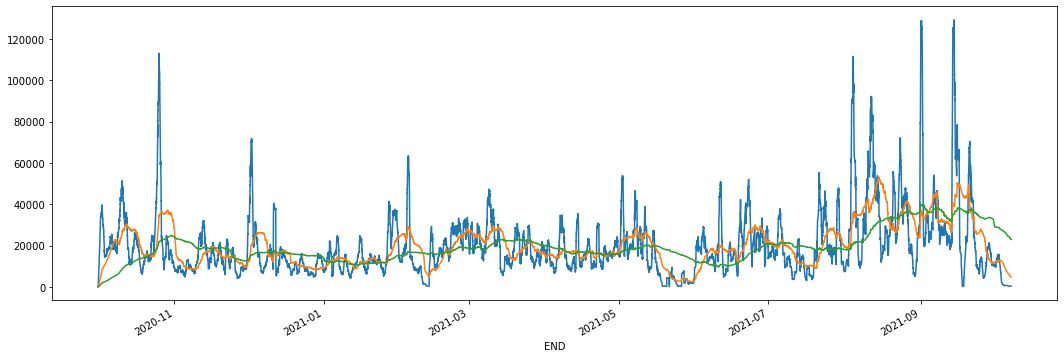

In [68]:
plt.figure(figsize = (18,6))
jobs.set_index('END')['ROLL1DAY'].plot()
jobs.set_index('END')['ROLL7DAYAVG'].plot()
jobs.set_index('END')['ROLL30DAYAVG'].plot()

(array([  87944.,  468982., 1436362., 1520942., 1377031.,  962057.,
         639477.,  464209.,  290269.,  136556.]),
 array([1.42857143e-01, 5.32141429e+03, 1.06426857e+04, 1.59639571e+04,
        2.12852286e+04, 2.66065000e+04, 3.19277714e+04, 3.72490429e+04,
        4.25703143e+04, 4.78915857e+04, 5.32128571e+04]),
 <BarContainer object of 10 artists>)

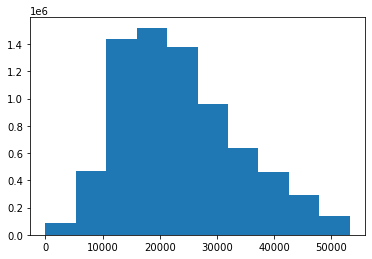

In [69]:
plt.hist(jobs['ROLL7DAYAVG'])

<AxesSubplot:xlabel='END'>

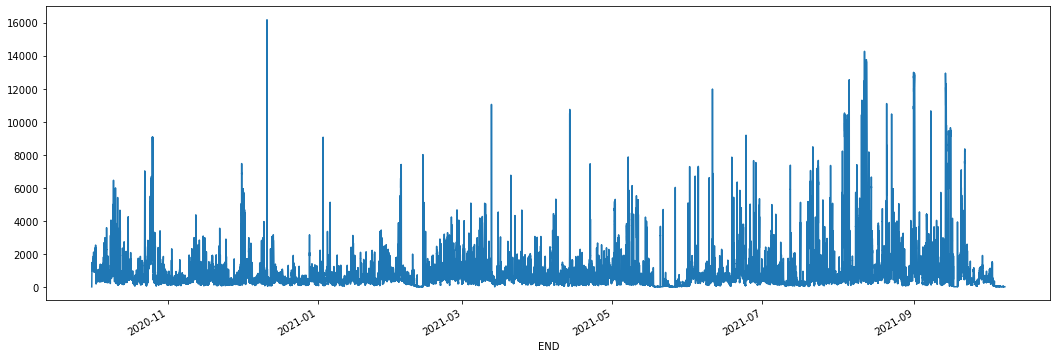

In [66]:
plt.figure(figsize = (18,6))
jobs.set_index('END')['ROLL1HOUR'].plot()

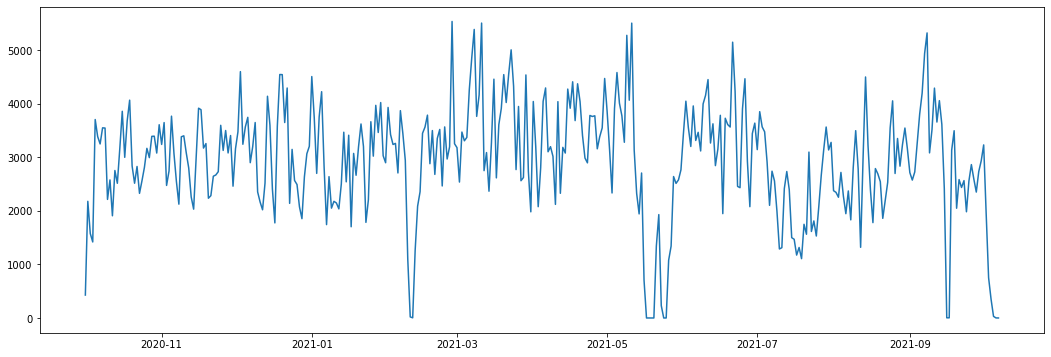

In [70]:
begin_load_df = jobs[jobs['PARTITION'] == 'production'][['BEGIN']].rename(columns={'BEGIN':'TIME'})
begin_load_df['process'] = 1
end_load_df = jobs[jobs['PARTITION'] == 'production'][['END']].rename(columns={'END':'TIME'})
end_load_df['process'] = -1
load_df = begin_load_df.append(end_load_df)

resample_interval = "D"
fs_ts = pd.Series(list(load_df['process']), index=list(load_df['TIME']))
fs_resample = fs_ts.resample(resample_interval).sum().to_frame().cumsum()

plt.figure(figsize=(18, 6))
plt.plot(fs_resample.index, fs_resample[0])
